<a href="https://colab.research.google.com/github/Azeezmariam/Language_dectection_summative/blob/main/Mariam_Azeez_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LANGUAGE DETECTION

In [1]:
#Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score



In [2]:
pip install tensorflow pandas scikit-learn

In [3]:
# Load the dataset to preview its structure
file_path = '/content/EACLanguageDetectionDataSet.csv'
df = pd.read_csv(file_path)

# Show basic info and first few rows of the dataset
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      3999 non-null   object
 1   Language  3999 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


(None,
                                                 Text Language
 0   Nature, in the broadest sense, is the natural...  English
 1  "Nature" can refer to the phenomena of the phy...  English
 2  The study of nature is a large, if not the onl...  English
 3  Although humans are part of nature, human acti...  English
 4  [1] The word nature is borrowed from the Old F...  English)

Class Distribution Before Balancing:
 Language
English        1385
Kinyarwanda    1017
French         1014
Kiswahili       583
Name: count, dtype: int64
Class Distribution After Balancing:
 Language
Kiswahili      1385
Kinyarwanda    1385
English        1385
French         1385
Name: count, dtype: int64
Training set size: 4432
Validation set size: 554
Test set size: 554


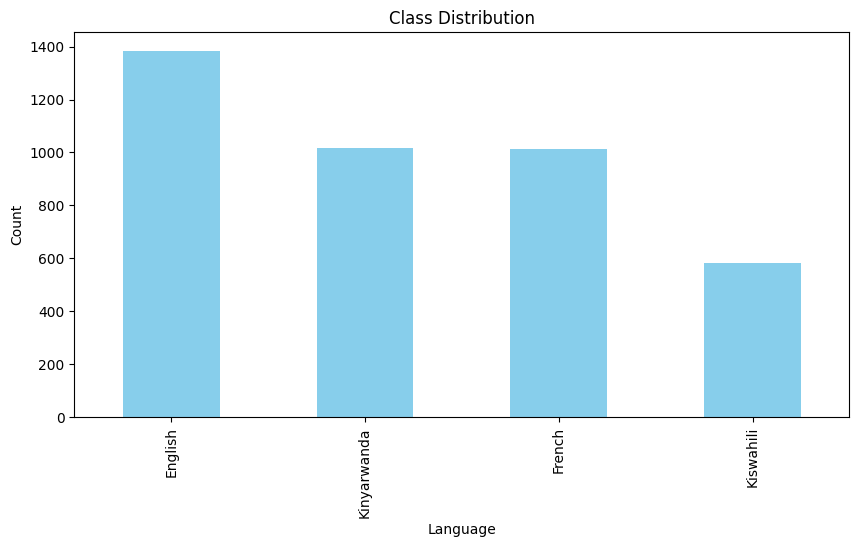

((4432, 5000), (554, 5000), (554, 5000))

In [4]:
#Data Preprocessing
# Step 1: Lowercasing
df['Text'] = df['Text'].str.lower()

# Step 2: Remove punctuation
df['Text'] = df['Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Step 3: Check class balance
class_distribution = df['Language'].value_counts()
print("Class Distribution Before Balancing:\n", class_distribution)

# Step 4: Address Class Imbalance
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = df[df['Language'] == class_distribution.idxmax()]
minority_classes = [df[df['Language'] == lang] for lang in class_distribution.index if lang != class_distribution.idxmax()]

# Resample minority classes
balanced_classes = [resample(minority, replace=True, n_samples=len(majority_class), random_state=42) for minority in minority_classes]

# Combine all classes
df_balanced = pd.concat([majority_class] + balanced_classes)
df_balanced = df_balanced.sample(frac=1, random_state=42)  # Shuffle the dataset

# Check new class distribution
print("Class Distribution After Balancing:\n", df_balanced['Language'].value_counts())

# Step 5: Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words=None, max_features=5000)  # Stop words disabled for minority language features
X = vectorizer.fit_transform(df_balanced['Text'])

# Extract target variable
y = df_balanced['Language']

# Split the dataset into training, validation, and test sets (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


# Plot the class distribution
plt.figure(figsize=(10,5))
class_distribution.plot(kind='bar', title='Class Distribution', color='skyblue')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

X_train.shape, X_val.shape, X_test.shape


In [5]:
# Encode the target labels (Language) to numeric values
label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_val_enc = to_categorical(label_encoder.transform(y_val))
y_test_enc = to_categorical(label_encoder.transform(y_test))

# Get the number of unique classes (languages)
num_classes = y_train_enc.shape[1]
print("Number of unique classes:", num_classes)

Number of unique classes: 4


In [6]:
#VANNILA MODEL
#Build the simple neural network model
model_1 = Sequential()
model_1.add(Dense(128, input_dim=5000, activation='relu'))  # Input layer and one hidden layer
model_1.add(Dense(num_classes, activation='softmax'))  # Output layer for multiclass classification


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
#Compile the model
model_1.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model on training data
history_1 = model_1.fit(X_train.toarray(), y_train_enc, validation_data=(X_val.toarray(), y_val_enc),
                        epochs=10, batch_size=32, verbose=1)

#Evaluate the model on the test set
test_loss_1, test_acc_1 = model_1.evaluate(X_test.toarray(), y_test_enc, verbose=0)

#Print the test accuracy and loss
print(f"Test Accuracy: {test_acc_1}")
print(f"Test Loss: {test_loss_1}")

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8450 - loss: 1.0745 - val_accuracy: 0.9729 - val_loss: 0.2879
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9880 - loss: 0.1685 - val_accuracy: 0.9801 - val_loss: 0.0996
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9931 - loss: 0.0552 - val_accuracy: 0.9838 - val_loss: 0.0626
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9942 - loss: 0.0303 - val_accuracy: 0.9874 - val_loss: 0.0466
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9963 - loss: 0.0196 - val_accuracy: 0.9928 - val_loss: 0.0386
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9954 - loss: 0.0178 - val_accuracy: 0.9928 - val_loss: 0.0338
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9966 - loss: 0.0137 - val_accuracy: 0.9928 - val_loss: 0.0311
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9937 - loss: 0.0150 - val_accuracy: 0

In [10]:
#Save the model in the new Keras format
model_1.save('language_detection_model.keras')

In [9]:
#Save model as pickle
import pickle
filename = 'language_detection_model.pkl'
# Save the model to a file
with open(filename, 'wb') as file: # Use the 'filename' variable here
    pickle.dump(model_1, file) # Assuming you want to save model_1, not 'model'

print(f"Model saved to {filename}") # Use the 'filename' variable here as well

Model saved to language_detection_model.pkl


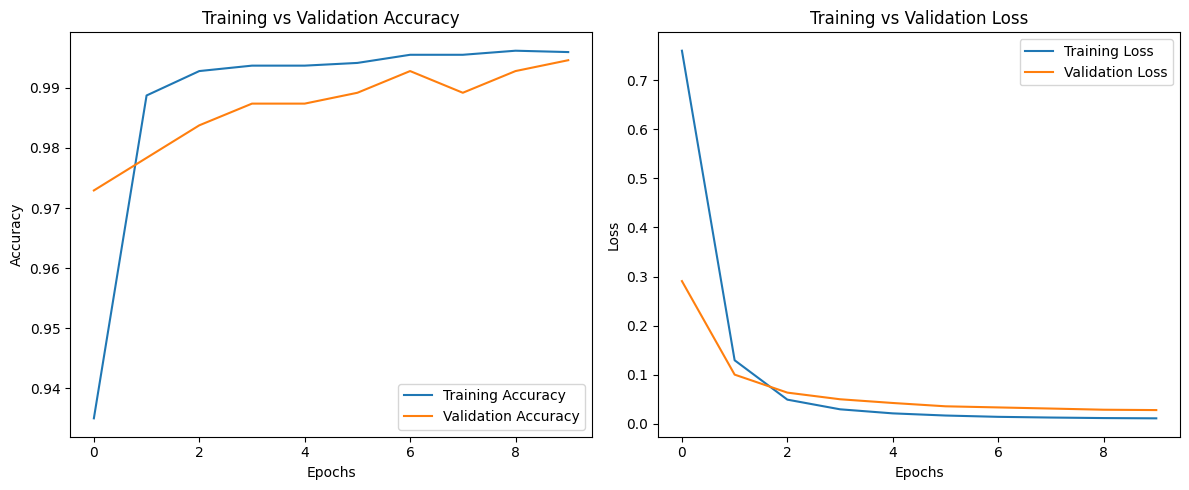

In [9]:
#Visualization of first model

# Plot training vs validation accuracy
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [10]:
#Make predictions

# Example input: A list of sentences for language detection
example_sentences = [
    "Hello, how are you?",
    "Bonjour, comment ça va?",
    "Habari, unafanya aje?",
    "Muraho, amakuru?"
]

# Preprocess the example sentences
# Convert text to the same vectorized form used for training
example_vectors = vectorizer.transform(example_sentences).toarray()

# Make predictions
predictions = model_1.predict(example_vectors)

# Convert probabilities to class labels
predicted_classes = predictions.argmax(axis=1)

# Map predicted classes back to language labels (Swahili, French, English, Kinyarwanda)
class_to_language = {
    0: "English",
    1: "French",
    2: "Kinyarwanda",
    3: "Kiswahili"
}
predicted_languages = [class_to_language[cls] for cls in predicted_classes]

# Print the predictions
for sentence, language in zip(example_sentences, predicted_languages):
    print(f"Sentence: \"{sentence}\" -> Predicted Language: {language}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Sentence: "Hello, how are you?" -> Predicted Language: English
Sentence: "Bonjour, comment ça va?" -> Predicted Language: French
Sentence: "Habari, unafanya aje?" -> Predicted Language: Kiswahili
Sentence: "Muraho, amakuru?" -> Predicted Language: Kinyarwanda


In [11]:
#Model 2 training
#A model applying at least 3 optimization techniques
#Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9  # Reduce learning rate by 10% after each epoch

#Build the optimized neural network model
num_classes = len(label_encoder.classes_)  # Number of output classes
model_2 = Sequential()
model_2.add(Dense(128, input_dim=5000, activation='relu', kernel_regularizer=l2(0.001)))  # L2 Regularization
model_2.add(BatchNormalization())  # Batch normalization
model_2.add(Dropout(0.5))  # Dropout to prevent overfitting
model_2.add(Dense(num_classes, activation='softmax'))  # Output layer

#Compile the model with a different optimizer
adam_optimizer = Adam(learning_rate=0.001)
model_2.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model with a learning rate scheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)
history_2 = model_2.fit(X_train.toarray(), y_train_enc, validation_data=(X_val.toarray(), y_val_enc),
                        epochs=10, batch_size=32, callbacks=[lr_callback], verbose=1)


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8029 - loss: 0.6217 - val_accuracy: 0.9819 - val_loss: 1.0382 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9925 - loss: 0.0794 - val_accuracy: 0.9892 - val_loss: 0.6321 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9945 - loss: 0.0577 - val_accuracy: 0.9928 - val_loss: 0.2542 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9943 - loss: 0.0524 - val_accuracy: 0.9946 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9961 - loss: 0.0486 - val_accuracy: 0.9874 - val_loss: 0.0629 - learning_rate: 0.0010
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9943 - loss: 0.0506 - val_accuracy: 0.9874 - val_loss: 0.0581 - learning_rate: 9.0000e-04
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9959 - loss

In [12]:
#Evaluate the model on the test set
test_loss_2, test_acc_2 = model_2.evaluate(X_test.toarray(), y_test_enc, verbose=0)

#Print the test accuracy and loss
print(f"Test Accuracy: {test_acc_2:.4f}")
print(f"Test Loss: {test_loss_2:.4f}")


Test Accuracy: 0.9892
Test Loss: 0.0481


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


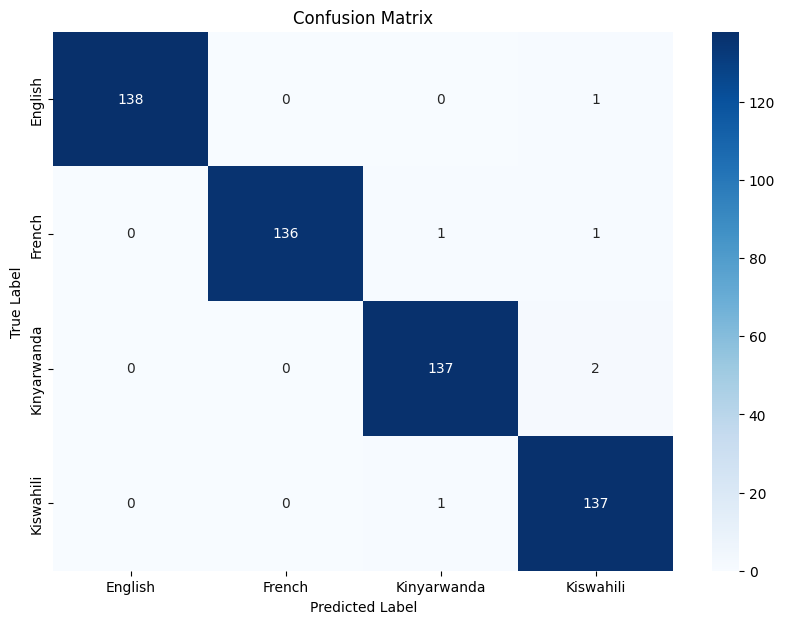

In [13]:
#ERROR ANALYSIS
#Predict on the test set
y_pred = model_2.predict(X_test.toarray())
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

#Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [14]:
#Classification Report (includes Precision, Recall, and F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

#F1 Score (macro average)
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score (Macro Average): {f1:.4f}")

#Specificity calculation for each class
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    true_negatives = cm.sum(axis=1) - np.diag(cm)
    false_positives = cm.sum(axis=0) - np.diag(cm)
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

specificity = specificity_score(y_true, y_pred_classes)
for idx, label in enumerate(label_encoder.classes_):
    print(f"Specificity for {label}: {specificity[idx]:.4f}")


Classification Report:
              precision    recall  f1-score   support

     English       1.00      0.99      1.00       139
      French       1.00      0.99      0.99       138
 Kinyarwanda       0.99      0.99      0.99       139
   Kiswahili       0.97      0.99      0.98       138

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554

F1 Score (Macro Average): 0.9892
Specificity for English: 1.0000
Specificity for French: 1.0000
Specificity for Kinyarwanda: 0.5000
Specificity for Kiswahili: 0.2000
